In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from google.colab import files

In [2]:
uploaded = files.upload()

import zipfile
import io

zip_name = next(iter(uploaded))
with zipfile.ZipFile(io.BytesIO(uploaded[zip_name]), 'r') as zip_ref:
    zip_ref.extractall('/content/')

Saving FER2013.zip to FER2013.zip


In [3]:
BATCH_SIZE = 256
EPOCHS = 30
NUM_CLASSES = 7
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

BASE_PATH = '/content'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
TEST_PATH = os.path.join(BASE_PATH, 'test')

In [4]:
EMOTION_LABELS = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

In [10]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 128, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            nn.Dropout(0.5)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, NUM_CLASSES)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        return x

In [11]:
print(f"Using device: {DEVICE}")
print(f"Training data path: {TRAIN_PATH}")
print(f"Testing data path: {TEST_PATH}")

train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = datasets.ImageFolder(
    root=TRAIN_PATH,
    transform=train_transform
)

test_dataset = datasets.ImageFolder(
    root=TEST_PATH,
    transform=test_transform
)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)


Using device: cuda:0
Training data path: /content/train
Testing data path: /content/test
Number of training samples: 28709
Number of testing samples: 7178


In [12]:
def train(model, device, train_loader, optimizer):

    model.train()

    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch_idx, (input, target) in enumerate(train_loader):
        input = input.to(DEVICE)
        target = target.type(torch.LongTensor).to(DEVICE)

        optimizer.zero_grad()
        output = model(input)

        loss = nn.CrossEntropyLoss()
        loss_value = loss(output, target)

        loss_value.backward()
        optimizer.step()

        train_loss += loss_value
        train_correct += torch.sum(torch.argmax(output, dim=1) == target)
        train_total += input.shape[0]

    avg_loss = train_loss.item() / len(test_loader)
    accuracy = (train_correct / train_total).item()

    return avg_loss, accuracy

In [13]:
def test(model, device, test_loader, optimizer):
    model.eval()

    test_loss = 0
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_idx, (input, target) in enumerate(test_loader):
            input = input.to(DEVICE)
            target = target.type(torch.LongTensor).to(DEVICE)

            output = model(input)
            predictions = torch.argmax(output, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            loss = nn.CrossEntropyLoss()
            loss_value = loss(output, target)

            test_loss += loss_value.item()
            test_correct += torch.sum(torch.argmax(output, dim=1) == target).item()
            test_total += input.shape[0]

    cm = confusion_matrix(all_targets, all_predictions)
    test_loss = test_loss / len(test_loader)
    accuracy = test_correct / test_total

    return test_loss, accuracy, cm

Epoch 1/30:
Train Loss: 6.8943 | Train Acc: 34.68%
Test Loss: 1.4459 | Test Acc: 45.90%
Epoch 2/30:
Train Loss: 5.9185 | Train Acc: 44.02%
Test Loss: 1.3148 | Test Acc: 50.98%
Epoch 3/30:
Train Loss: 5.4581 | Train Acc: 47.94%
Test Loss: 1.2593 | Test Acc: 52.08%
Epoch 4/30:
Train Loss: 5.1433 | Train Acc: 50.83%
Test Loss: 1.2185 | Test Acc: 53.47%
Epoch 5/30:
Train Loss: 4.9590 | Train Acc: 52.57%
Test Loss: 1.1789 | Test Acc: 54.58%
Epoch 6/30:
Train Loss: 4.8164 | Train Acc: 54.05%
Test Loss: 1.1420 | Test Acc: 56.10%
Epoch 7/30:
Train Loss: 4.6858 | Train Acc: 55.16%
Test Loss: 1.1281 | Test Acc: 56.85%
Epoch 8/30:
Train Loss: 4.6136 | Train Acc: 55.68%
Test Loss: 1.1052 | Test Acc: 57.51%
Epoch 9/30:
Train Loss: 4.4958 | Train Acc: 56.68%
Test Loss: 1.0866 | Test Acc: 58.93%
Epoch 10/30:
Train Loss: 4.4401 | Train Acc: 57.11%
Test Loss: 1.0835 | Test Acc: 58.78%
Epoch 11/30:
Train Loss: 4.3934 | Train Acc: 57.74%
Test Loss: 1.0589 | Test Acc: 59.96%
Epoch 12/30:
Train Loss: 4.319

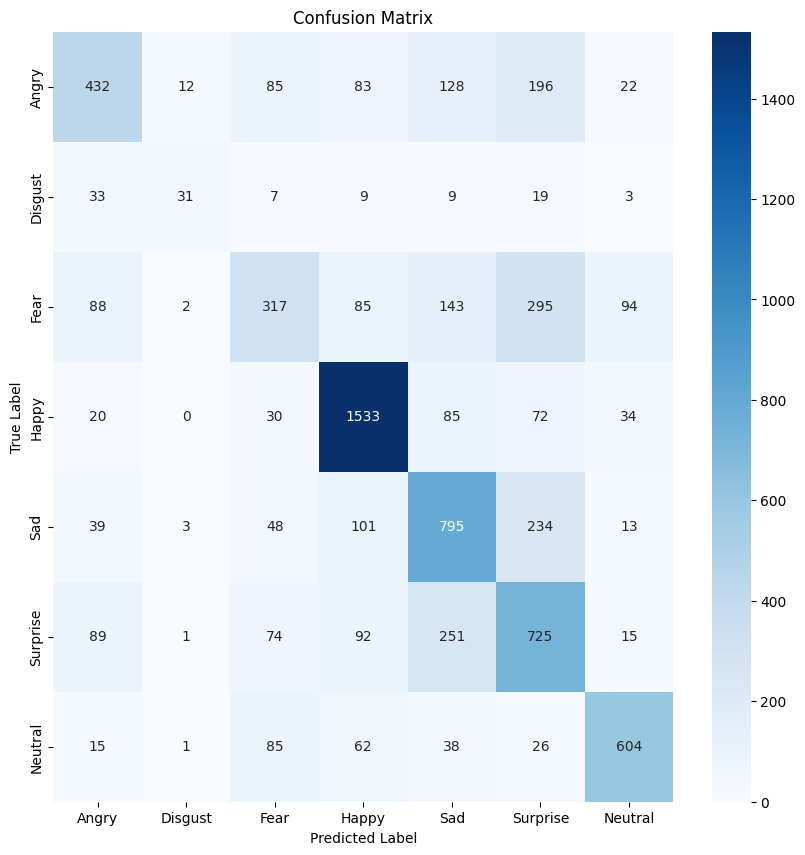

In [14]:
model = BaselineCNN().to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.01)

train_accuracies = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, DEVICE, train_loader, optimizer)
    test_loss, test_acc, cm = test(model, DEVICE, test_loader, optimizer)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f'Epoch {epoch+1}/{EPOCHS}:')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%')
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%')

    if epoch == 29:

      plt.figure(figsize=(10, 10))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                  xticklabels=EMOTION_LABELS.values(),
                  yticklabels=EMOTION_LABELS.values())
      plt.xlabel('Predicted Label')
      plt.ylabel('True Label')
      plt.title('Confusion Matrix')
      plt.show()


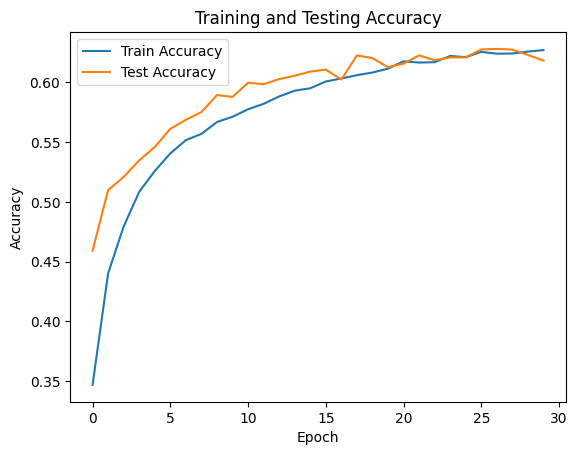

In [15]:
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()